In [211]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Bird Species Prediction Model

The objective of this project section is to develop a predictive model capable of identifying bird species from observational data. The primary focus is on Bird species 3 and Bird species 11, as these are of particular interest to the researchers at the feeding station. The goal is to achieve a model with an accuracy exceeding 80% and a high recall rate for these two specific bird species.

## Data Transformation for Model Training

In the process of preparing our data for model development, several steps were taken to streamline the dataset and enhance its suitability for predictive modeling. These steps are as follows:

   - **Feature Selection**: After conducting Exploratory Data Analysis (EDA), it was evident that certain categories, such as wind, had minimal influence on bird distribution and were deemed non-essential. To simplify the model and reduce noise, these categories were removed from the dataset.

   - **Datetime Columns Processing**: The datetime columns held valuable information for the model but required preprocessing and feature extraction. Given the seasonality of some bird species, the month of observation was extracted from the observation time. Additionally, recognizing that the hour of the day might correlate with certain behavioral patterns among bird species, the hour was also extracted. Subsequently, both the observation_dt and feeding_dt columns were dropped from the dataset. The time gap between food delivery and bird food location was transformed into the number of hours for further analysis.

   - **Categorical Features Transformation**: To incorporate categorical features into the model, including the extracted month of observation, they were converted into dummy variables. This conversion allows for the effective use of categorical information in model training.

   - **Target Variable Adjustment**: In order to maintain the model's integrity, observations for Bird species 1 and Bird species 5, which each had only one instance in the dataset, were removed. The target variable necessitates a minimum of two instances per class for accurate model training.

These data transformations were executed to optimize the dataset for the development of an effective predictive model.

In [212]:
# Import necessary packages
import pandas as pd
import pickle

# Load DataFrame from pickle
with open('df.pkl', 'rb') as file:
    df = pickle.load(file)

display(df.head())
df.info()

,bird,food,weight,temperature,weather,rain,wind,eats,duration,food_taken,observation_dt,feeding_dt,feeding_timegap
0,Bird 10,Feed 1,55.5,23,sunny,False,light,True,26,False,2017-08-08 08:09:00,2017-08-05 14:25:00,2 days 17:44:00
1,Bird 10,Feed 1,55.5,23,sunny,False,light,True,26,False,2017-08-08 08:09:00,2017-08-05 14:25:00,2 days 17:44:00
2,Bird 10,Feed 1,55.5,23,sunny,False,light,True,26,False,2017-08-08 08:09:00,2017-08-05 14:25:00,2 days 17:44:00
3,Bird 10,Feed 1,55.5,23,sunny,False,light,True,26,False,2017-08-08 08:09:00,2017-08-05 14:25:00,2 days 17:44:00
4,Bird 10,Feed 1,55.5,22,sunny,False,light,True,1,False,2017-08-09 08:08:00,2017-08-05 14:25:00,3 days 17:43:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6352 entries, 0 to 6351
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   bird             6352 non-null   category       
 1   food             6352 non-null   category       
 2   weight           6352 non-null   float64        
 3   temperature      6352 non-null   int64          
 4   weather          6352 non-null   category       
 5   rain             6352 non-null   bool           
 6   wind             6352 non-null   category       
 7   eats             6352 non-null   bool           
 8   duration         6352 non-null   int32          
 9   food_taken       6352 non-null   bool           
 10  observation_dt   6352 non-null   datetime64[ns] 
 11  feeding_dt       6352 non-null   datetime64[ns] 
 12  feeding_timegap  6352 non-null   timedelta64[ns]
dtypes: bool(3), category(4), datetime64[ns](2), float64(1), int32(1), int64(1), ti

In [213]:
# Convert datetime columns to datetime type
df['observation_dt'] = pd.to_datetime(df['observation_dt'])
df['feeding_dt'] = pd.to_datetime(df['feeding_dt'])

# Extract the hour of the day and create a new column 'hour_of_day'
df['hour_of_day'] = df['observation_dt'].dt.hour

# Extract the month names and create a new column 'month'
df['month'] = df['observation_dt'].dt.strftime('%B')

# Extract the year and create a new column 'year' as a categorical variable
df['year'] = df['observation_dt'].dt.year
df['year'] = df['year'].astype('category')

# Drop specified columns from the DataFrame
col_to_drop = ["wind", 'observation_dt', 'feeding_dt', 'feeding_timegap']
df.drop(col_to_drop, axis=1, inplace=True)

# Check which birds only have 1 observation and remove them from df
print(df['bird'].value_counts())
df = df[~((df['bird'] == 'Bird 1') | (df['bird'] == 'Bird 5'))]

# Display the modified DataFrame
display(df)

Bird 6     4048
Bird 10    1193
Bird 3      539
Bird 9      270
Bird 11     263
Bird 12      14
Bird 13       5
Bird 2        5
Bird 4        5
Bird 8        5
Bird 7        3
Bird 1        1
Bird 5        1
Name: bird, dtype: int64


,bird,food,weight,temperature,weather,rain,eats,duration,food_taken,hour_of_day,month,year
0,Bird 10,Feed 1,55.5,23,sunny,False,True,26,False,8,August,2017
1,Bird 10,Feed 1,55.5,23,sunny,False,True,26,False,8,August,2017
2,Bird 10,Feed 1,55.5,23,sunny,False,True,26,False,8,August,2017
3,Bird 10,Feed 1,55.5,23,sunny,False,True,26,False,8,August,2017
4,Bird 10,Feed 1,55.5,22,sunny,False,True,1,False,8,August,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
6347,Bird 6,Feed 1,32.5,22,sunny,False,True,61,False,7,August,2018
6348,Bird 6,Feed 1,32.5,22,sunny,False,True,61,False,7,August,2018
6349,Bird 3,Feed 1,32.5,24,sunny,False,True,123,False,7,August,2018
6350,Bird 3,Feed 1,32.5,24,sunny,False,True,16,False,8,August,2018


## Multi-Class Classifier Model Development
### Baseline Models

In the context of multi-class classifier model development, two baseline models were created to establish a performance benchmark for evaluating advanced machine learning models. The purpose of these baseline models was to assess their accuracy on the dataset without introducing complexities associated with more advanced techniques.

   - **Majority Class Classifier**: A baseline model was designed to predict the majority class, which was Bird 6, considering that it represented over 60% of the dataset's observations. The accuracy achieved by this model was approximately 64%, closely reflecting the proportion of Bird 6 instances in the dataset.

   - **Stratified Classifier**: To address class imbalance while maintaining a more sophisticated approach than simply predicting the majority class, a stratified classifier was employed. This model generated random predictions while preserving the distribution of different bird species observed in the training set. Given the significant class imbalance in the dataset, the stratified classifier served as a valuable point of reference for evaluating more complex models. The accuracy achieved by the stratified classifier was 46%, indicating that random predictions based on class distribution alone yielded relatively ineffective results.

These baseline models serve as reference points for assessing the performance of advanced machine learning models as the model development and optimization process progresses.

In [214]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier

# Instantiate the scaler
scaler = MinMaxScaler()

# Separate the feature variables and the target variable
X = df.drop("bird", axis=1)
y = df["bird"]

# Create dummy variables for categorical features
X = pd.get_dummies(X, drop_first=True)

# Use the MinMaxScaler to scale the numerical features
numerical_values = ['weight', 'temperature', 'duration', 'hour_of_day']
X.loc[:, numerical_values] = scaler.fit_transform(X.loc[:, numerical_values])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Predict the majority class for all instances in the test set
majority_class = y_train.mode()
y_pred_mcc = [majority_class] * len(y_test)

# Instantiate and fit a stratified dummy classifier
stratified_classifier = DummyClassifier(strategy='stratified', random_state=123)
stratified_classifier.fit(X_train, y_train)

# Predict using the stratified classifier
y_pred_sc = stratified_classifier.predict(X_test)

# Calculate precision
accuracy_st = accuracy_score(y_test, y_pred_sc)
accuracyn_mcc = accuracy_score(y_test, y_pred_mcc)

print(f"Majority Class Classifier's accuracy: {precision_mcc:.4f}")
print(f"Stratified Classifier's accuracy: {precision_st:.4f}")

Majority Class Classifier's accuracy: 0.6373
Stratified Classifier's accuracy: 0.4635


### Random Forest Classifier

The initial step in the development of the first multi-class classifier model involved an examination of the untuned Random Forest Classifier, along with an exploration of its metrics and feature importance via a bar chart. This analysis revealed that the most crucial feature in the model was the duration (the time spent by the bird at the feeding station), followed by temperature and hour of the day, in that order. These findings indicated significant behavioral variations among different bird species, with each species exhibiting distinct durations of stay, visitation times, and temperature preferences. It is worth noting that there may be a correlation between temperature and the hour of the day.

The untuned Random Forest Classifier achieved an overall accuracy of 87%. However, the recall scores for Bird 11 and Bird 3 were 0.32 and 0.70, respectively. This suggests that identifying Bird 11 based solely on its behavior is challenging compared to Bird 3.

To enhance the recall scores for Bird 3 and Bird 11, which are the target birds of interest, a hyperparameter tuning process was performed on the Random Forest Classifier. Specifically, the hyperparameters "n_estimators" and "class_weight" were adjusted. The model's accuracy and recall scores for Bird 3 and Bird 11 were assessed across various combinations of these hyperparameters, resulting in the creation of three distinct plots.

Following the analysis of these plots, the optimized model that best serves the project's objectives utilizes "balanced subsample" as the class weight and employs 200 estimators. While this tuned model does slightly reduce the overall accuracy to 0.86, as well as the recall for Bird 11 to 0.30 (a decrease of 0.01 and 0.02, respectively, compared to the untuned model), it achieves a notable improvement in the recall score for Bird 3, raising it to 0.75, an increase of 0.05 compared to the untuned model.

              precision    recall  f1-score   support

     Bird 10       0.80      0.80      0.80       358
     Bird 11       0.40      0.32      0.35        79
     Bird 12       1.00      0.25      0.40         4
     Bird 13       0.50      1.00      0.67         1
      Bird 2       0.00      0.00      0.00         2
      Bird 3       0.72      0.70      0.71       162
      Bird 4       0.00      0.00      0.00         2
      Bird 6       0.94      0.97      0.95      1214
      Bird 7       0.00      0.00      0.00         1
      Bird 8       1.00      1.00      1.00         1
      Bird 9       0.67      0.52      0.58        81

    accuracy                           0.87      1905
   macro avg       0.55      0.50      0.50      1905
weighted avg       0.86      0.87      0.86      1905

[0.3164557]


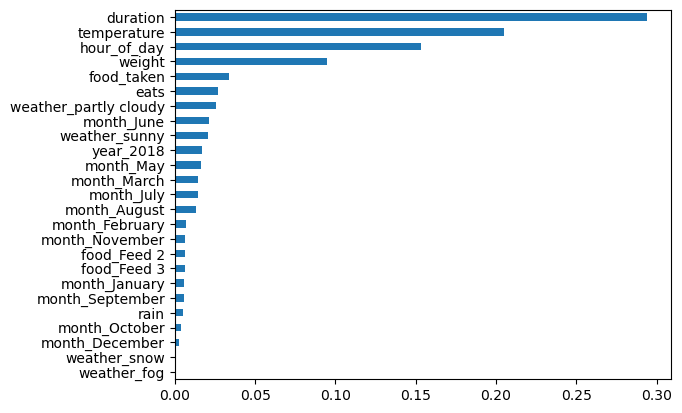

In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, classification_report, accuracy_score

# Instantiate the RandomForestClassifier with a specified random seed
rf_classifier = RandomForestClassifier(random_state=123)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
rf_predictions = rf_classifier.predict(X_test)

# Calculate classification report, including recall, precision, etc.
report_rf = classification_report(y_test, rf_predictions, zero_division=0)

# Print model metrics for the entire model and for each bird species
print(report_rf)
print(recall)  # It's unclear where 'recall' variable is defined, it should be 'recall_score'

# Calculate and plot feature importances
importances_rf = pd.Series(rf_classifier.feature_importances_, index=X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh')
plt.show()

,Balanced,Balanced Subsample,Unbalanced
100,0.861942,0.862992,0.865092
200,0.862992,0.862467,0.869291
300,0.863517,0.862992,0.869816


,Balanced,Balanced Subsample,Unbalanced
100,0.734568,0.753086,0.697531
200,0.728395,0.746914,0.709877
300,0.734568,0.746914,0.728395


,Balanced,Balanced Subsample,Unbalanced
100,0.303797,0.291139,0.316456
200,0.303797,0.303797,0.329114
300,0.278481,0.291139,0.316456


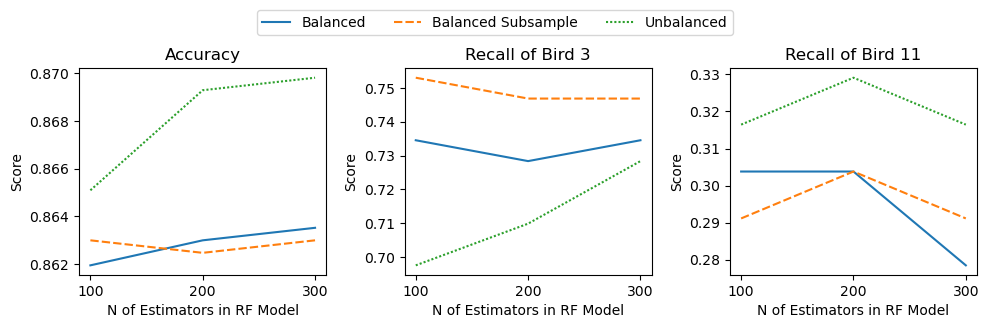

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Define a list of different numbers of estimators
n_estimators = [100, 200, 300]

# Define scoring metrics to evaluate the models
scorings = ["Accuracy", "Recall of Bird 3", "Recall of Bird 11"]

# Iterate through the scoring metrics
for i, s in enumerate(scorings):
    # Lists to store scores for different class weights
    balanced_scores = []
    balanced_subsample_scores = []
    unbalanced_score = []
    
    # Dictionary to map class weights to their respective score lists
    class_weights_dict = {"balanced": balanced_scores,
                          "balanced_subsample": balanced_subsample_scores,
                          None: unbalanced_score}
    
    # Iterate through the number of estimators
    for n_estimator in n_estimators:
        for key, value in class_weights_dict.items():
            # Create a RandomForestClassifier with specified parameters
            rf_classifier = RandomForestClassifier(n_estimators=n_estimator,
                                                   class_weight=key, random_state=123)
            # Fit the model on the training data
            rf_classifier.fit(X_train, y_train)

            # Make predictions on the test data
            rf_predictions = rf_classifier.predict(X_test)
            
            # Calculate the score based on the selected metric
            if s == "Accuracy":
                score = accuracy_score(y_test, rf_predictions)
            elif s == "Recall of Bird 3":
                recall = recall_score(y_test, rf_predictions, labels=['Bird 3'], average=None)
                score = recall[0]
            else: 
                recall = recall_score(y_test, rf_predictions, labels=['Bird 11'], average=None)
                score = recall[0]
            
            # Append the score to the respective list
            value.append(score)

    # Create a DataFrame to be plotted with scores and estimator values            
    df_scores = pd.DataFrame({"Balanced": balanced_scores, "Balanced Subsample": balanced_subsample_scores, "Unbalanced": unbalanced_score})
    df_scores.index = n_estimators

    # Plot the relationship between 'n_estimators' and scores
    sns.lineplot(data=df_scores, ax=axes[i])
    axes[i].set_xticks(n_estimators)
    axes[i].set_xlabel("N of Estimators in RF Model")
    axes[i].set_ylabel("Score")
    axes[i].set_title(s)
    axes[i].legend()
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    
    # Display the metric scores for each combination of tested hyperparameters
    df_scores = df_scores.style.set_caption(s)
    display(df_scores)

# Create a common figure legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.tight_layout()
plt.show()


### XGB Classifier

The investigation into model performance improvement involved transitioning from a Random Forest classifier to the XGBoost (XGB) Classifier, a model particularly suited for multiclass classification tasks, with significant potential for hyperparameter optimization.

Initially, the XGB Classifier underwent training and testing on the dataset with its default model settings in its hyperparameters. As for the random forest model, a metric report offering an overarching assessment of its performance in the context of Bird species classification was yielded. The resulting accuracy was recorded at 0.85, with the recall values for Bird 11 and Bird 3 standing at 0.29 and 0.75, respectively. These outcomes closely resembled those obtained from the fine-tuned Random Forest classifier, albeit with a marginal decrement of 0.01 in both overall model accuracy and Bird 11 recall.

Subsequently, the focus shifted towards the hyperparameter tuning of various aspects of the XGB Classifier. A randomized search was conducted across a custom parameter grid, employing cross-validation and giving priority to optimizing the recall metric for Bird 11, which represented the weakest metric of interest performance in the model. Following the fine-tuning process, an assessment report was generated and analyzed. The findings revealed that despite the rigorous parameter exploration, there was no discernible enhancement in the recall of Bird 11. Instead, the recall for Bird 6 experienced a notable decline to 0.69. However, it is pertinent to note that the overall accuracy of the model exhibited a modest increment of 0.01, reaching a level of 0.86. These results collectively suggest that the default settings of the XGB Classifier may already be well-suited for our specific classification problem.

In [217]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Encode the target variable y_train so its suited for the XGB Classifier
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Instantiate the XGBClassifier
xgb_classifier = XGBClassifier(random_state=123)

# Fit the model on the training data
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions on the test data
xgb_predictions_encoded  = xgb_classifier.predict(X_test)

# Inverse transform the encoded predictions to get original labels
xgb_predictions = label_encoder.inverse_transform(xgb_predictions_encoded)

# Calculate accuracy
report_xgbc = classification_report(y_test, xgb_predictions, zero_division=0)

# Print model metrics for whole model and for each bird
print(report_xgbc)

              precision    recall  f1-score   support

     Bird 10       0.78      0.75      0.76       358
     Bird 11       0.40      0.29      0.34        79
     Bird 12       1.00      0.25      0.40         4
     Bird 13       0.50      1.00      0.67         1
      Bird 2       0.00      0.00      0.00         2
      Bird 3       0.77      0.75      0.76       162
      Bird 4       0.00      0.00      0.00         2
      Bird 6       0.93      0.97      0.95      1214
      Bird 7       0.00      0.00      0.00         1
      Bird 8       1.00      1.00      1.00         1
      Bird 9       0.53      0.48      0.51        81

    accuracy                           0.85      1905
   macro avg       0.54      0.50      0.49      1905
weighted avg       0.84      0.85      0.85      1905



In [218]:
from sklearn.metrics import classification_report, make_scorer, recall_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Encode the target variable y_train so it's suited for the XGB Classifier
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Instantiate the XGBClassifier
xgb_classifier = XGBClassifier(random_state=123)

# Define a custom scoring function for recall of a specific class (e.g., class 0)
def custom_recall_scorer(y_true, y_pred):
    class_index = 1  # Change this index to the desired class
    return recall_score(y_true, y_pred, average=None)[class_index]

# Define hyperparameters to search over
param_dist = {
    'n_estimators': np.arange(50, 501, 50),
    'max_depth': np.arange(1, 11),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations as needed
    scoring= make_scorer(custom_recall_scorer),
    cv=5,  # Number of cross-validation folds
    random_state=1,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model on the training data using RandomizedSearchCV
random_search.fit(X_train, y_train_encoded)

# Get the best estimator and its hyperparameters
best_xgb_classifier = random_search.best_estimator_
best_params = random_search.best_params_

# Print the values of the optimal hyperparameters
print("Best Hyperparameters:", best_params)

# Make predictions on the test data
xgb_predictions_encoded = best_xgb_classifier.predict(X_test)

# Inverse transform the encoded predictions to get original labels
xgb_predictions = label_encoder.inverse_transform(xgb_predictions_encoded)

# Calculate accuracy
report_xgbc = classification_report(y_test, xgb_predictions, zero_division=0)

# Print model metrics for the whole model and for each bird
print(report_xgbc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\lucas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.9}
              precision    recall  f1-score   support

     Bird 10       0.78      0.81      0.79       358
     Bird 11       0.38      0.29      0.33        79
     Bird 12       1.00      0.25      0.40         4
     Bird 13       0.50      1.00      0.67         1
      Bird 2       0.00      0.00      0.00         2
      Bird 3       0.74      0.69      0.71       162
      Bird 4       0.00      0.00      0.00         2
      Bird 6       0.94      0.97      0.95      1214
      Bird 7       0.00      0.00      0.00         1
      Bird 8       1.00      1.00      1.00         1
      Bird 9       0.62      0.51      0.56        81

    accuracy                           0.86      1905
   macro avg       0.54      0.50      0.49      1905
weighted avg       0.85      0.86      0.86      1905



## Summary & Conclusion

The multi-class classifier model development process began with the establishment of two baseline models: the Majority Class Classifier and the Stratified Classifier. These models served as foundational benchmarks for performance evaluation.

The initial exploration of the Random Forest Classifier yielded an accuracy of 87%. However, challenges were encountered in achieving high recall for Bird 11. Through hyperparameter tuning, improvements were made in Bird 3 recall without compromising overall accuracy.

Transitioning to the XGBoost Classifier, initial results closely mirrored those of the fine-tuned Random Forest model. Hyperparameter tuning, with a focus on enhancing Bird 11 recall, produced mixed outcomes. While there was no substantial improvement in Bird 11 recall, there was a decline in Bird 6 recall. Notably, the overall accuracy experienced a modest increase.

In summary, the examination of various classifier models and hyperparameter tuning underscored the nuanced nature of the classification problem. While no singular model achieved a definitive enhancement in Bird 11 recall, the exploration yielded valuable insights and optimized models aligned with project objectives. Future avenues for improving performance may involve further investigation into feature engineering and data augmentation.